In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
from tqdm import tqdm
# import pickle

import sys
sys.path.append('../functions')
import hexbin_functions as hexfunc

/nethome/6525954/.conda/envs/nemo-ensemble/lib/python3.12/site-packages/h3/unstable/__init__.py:4: UserWarning: Modules under `h3.unstable` are experimental, and may change at any time.
  warnings.warn(


In [2]:
def Shannon_entropy(Pdf):
    # Pdf = Pdf / np.nansum(Pdf)  # Normalize Pdf to sum to 1, ignoring NaNs
    # Replace zeros with a very small number to avoid log(0)
    Pdf_safe = np.where(Pdf > 0, Pdf, np.finfo(float).eps)
    return -np.nansum(Pdf_safe * np.log2(Pdf_safe))

def KLD(P, Q):
    """
    Kullback-Leibler divergence between two probability distributions P and Q.

    """
    P = np.where(P > 0, P, np.finfo(float).eps)
    Q = np.where(Q > 0, Q, np.finfo(float).eps)
    
    kld = np.nansum(P * np.log2(P/Q), axis=0)
    
    return kld

def JSD(P, Q):
    """
    Jensen-Shannon divergence between two probability distributions P and Q.

    """
    P = np.where(P > 0, P, np.finfo(float).eps)
    Q = np.where(Q > 0, Q, np.finfo(float).eps)
    
    M = 0.5 * (P + Q)
    jsd = 0.5 * KLD(P, M) + 0.5 * KLD(Q, M)
    
    return jsd

In [3]:
location = 'Cape_Hatteras'
delta_r = 0.1
subset = 1

week = 12
member = 1

file_path_AX = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_all/P_dr{delta_r*100:03.0f}_all_s{subset}.nc"
P_AX = xr.open_dataset(file_path_AX)
P_AX = P_AX.sortby('hexint')

file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_temporal/P_W{week:01d}_m{member:03d}.nc"
P_m = xr.open_dataset(file_path)
P_m = P_m.sortby('hexint')

    

In [4]:
M = (P_AX['probability'] + P_m['probability'])/2
M = M.values

In [5]:
hex_grid = hexfunc.int_to_hex(P_AX.hexint.values)
hexbin_grid = hexfunc.hexGrid(hex_grid, h3_res=3)

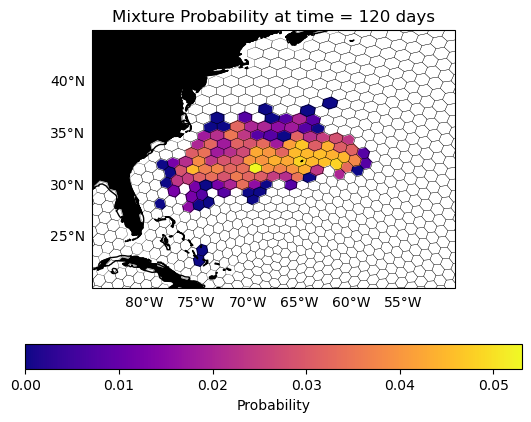

In [6]:
# Plot NA_domain on a map
depth = 0
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([-85, -50, 20, 45], crs=cartopy.crs.PlateCarree())
ax.coastlines()

ax.add_feature(cartopy.feature.LAND, zorder=0, color='black')
gl = ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5, alpha=0.)
gl.top_labels = False
gl.right_labels = False

t = 120
t_gap = 0

im = hexbin_grid.pcolorhex(M[:, t], ax=ax, cmap='plasma', draw_edges=True)
ax.set_title(f'Mixture Probability at time = {t} days')


cbar = plt.colorbar(im, ax=ax, orientation='horizontal', label=f'Probability')


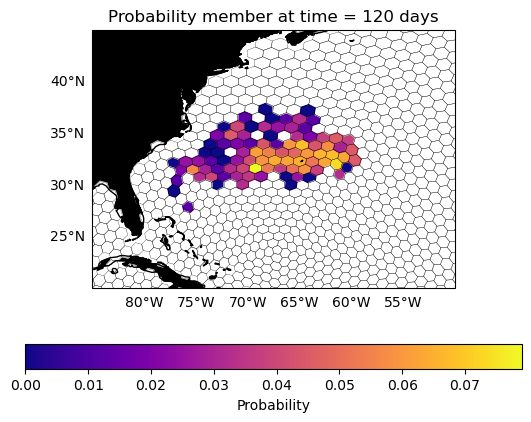

In [23]:
# Plot NA_domain on a map
depth = 0
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([-85, -50, 20, 45], crs=cartopy.crs.PlateCarree())
ax.coastlines()

ax.add_feature(cartopy.feature.LAND, zorder=0, color='black')
gl = ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5, alpha=0.)
gl.top_labels = False
gl.right_labels = False

t = 120
t_gap = 0

im = hexbin_grid.pcolorhex(P_m.probability[:, t], ax=ax, cmap='plasma', draw_edges=True)
ax.set_title(f'Probability member at time = {t} days')


cbar = plt.colorbar(im, ax=ax, orientation='horizontal', label=f'Probability')


# JSD all members Spatial

In [7]:
delta_r_ranges = np.linspace(1, 10, 10)/10

In [32]:
JSD_spatial = {}
JSD_mean_spatial = np.zeros((len(delta_r_ranges), len(P_AX['entropy'].values)))
JSD_STD_spatial = np.zeros((len(delta_r_ranges), len(P_AX['entropy'].values)))
    
for i, delta_r in enumerate(delta_r_ranges):
    
    _jsd = np.zeros((50, len(P_AX['entropy'].values)))
    
    for j, member in enumerate(range(1, 51)):
        file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_spatial/P_dr{delta_r*100:03.0f}_m{member:03d}.nc"
        P_m = xr.open_dataset(file_path)
        P_m = P_m.sortby('hexint')
        
        _jsd[j] = JSD(P_m['probability'].values, P_AX['probability'].values)
        
    JSD_spatial[delta_r] = _jsd
    JSD_mean_spatial[i] = np.mean(_jsd, axis=0)

In [16]:
delta_r_ranges

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

Text(0.5, 0, 'Time (days)')

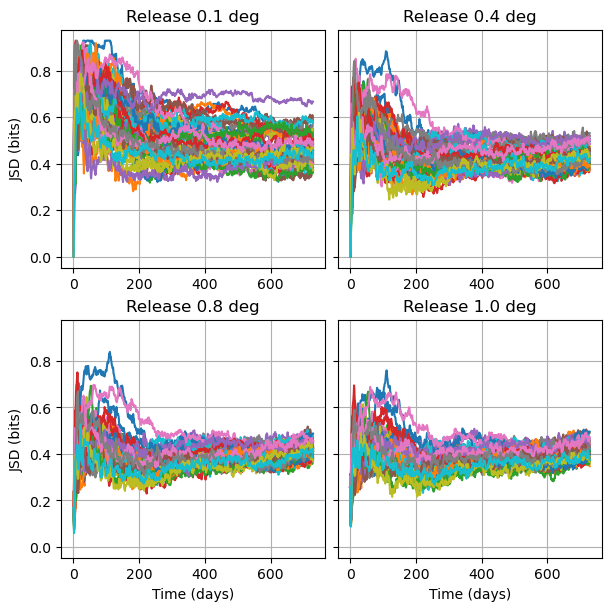

In [33]:
member_list = range(1, 51)
ncol = 2
nrow = 2
fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(6, 6),
                       sharey=True, constrained_layout=True)

axs = axs.reshape(ncol*nrow)

for i, delta_r in enumerate([0.1, 0.4, 0.8, 1.0]):

    for member in member_list:
        axs[i].plot(JSD_spatial[delta_r][member-1])
        # axs[i].plot(mean_entropy_all_01, ls='--', color='black', label='Mean All Members')
        
    axs[i].grid()
    axs[i].set_title(f'Release {delta_r} deg')
    # axs[i].set_xlabel('Time (days)')
    
axs[0].set_ylabel('JSD (bits)')
axs[2].set_ylabel('JSD (bits)')
axs[2].set_xlabel('Time (days)')
axs[3].set_xlabel('Time (days)')

Text(0.5, 1.0, 'Average JSD All Members Spatial')

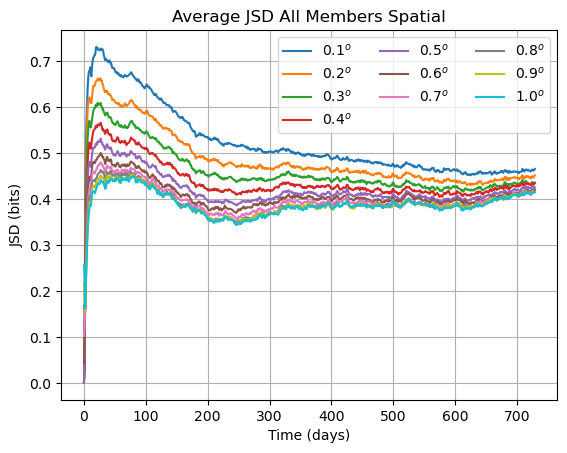

In [34]:
for i, delta_r in enumerate(delta_r_ranges):
    plt.plot(JSD_mean_spatial[i], label=f'${delta_r:.1f}^o$')

plt.legend(ncol=3)
plt.ylabel('JSD (bits)')
plt.xlabel('Time (days)')
plt.grid()
plt.title('Average JSD All Members Spatial')

# JSD Temporal 

In [35]:
week_range = [4, 8, 12, 16]
JSD_temporal = {}
JSD_mean_temporal = np.zeros((len(week_range), len(P_AX['entropy'].values)))
    
for i, week in enumerate(week_range):
    _jsd = np.zeros((50, len(P_AX['entropy'].values)))
    
    for j, member in enumerate(range(1, 51)):
        file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_temporal/P_W{week:01d}_m{member:03d}.nc"
        P_m = xr.open_dataset(file_path)
        P_m = P_m.sortby('hexint')
        
        _jsd[j] = JSD(P_m['probability'].values, P_AX['probability'].values)
        
    JSD_temporal[week] = _jsd
    JSD_mean_temporal[i] = np.mean(_jsd, axis=0)

In [36]:
JSD_temporal[4].shape

(50, 730)

Text(0.5, 0, 'Time (days)')

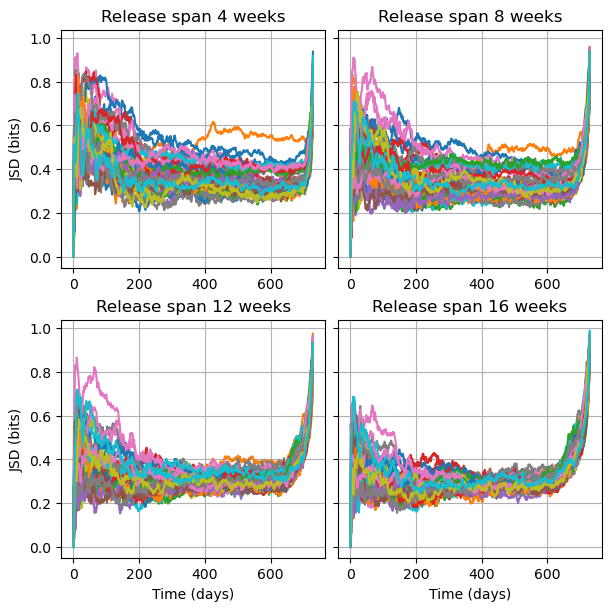

In [37]:
member_list = range(1, 51)
ncol = 2
nrow = 2
fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(6, 6),
                       sharey=True, constrained_layout=True)

axs = axs.reshape(ncol*nrow)

for i, week in enumerate(week_range):

    for member in member_list:
        axs[i].plot(JSD_temporal[week][member-1])
        # axs[i].plot(mean_entropy_all_01, ls='--', color='black', label='Mean All Members')
        
    axs[i].grid()
    axs[i].set_title(f'Release span {week} weeks')
    # axs[i].set_xlabel('Time (days)')
    
axs[0].set_ylabel('JSD (bits)')
axs[2].set_ylabel('JSD (bits)')
axs[2].set_xlabel('Time (days)')
axs[3].set_xlabel('Time (days)')


Text(0.5, 1.0, 'Average JSD All Members temporal')

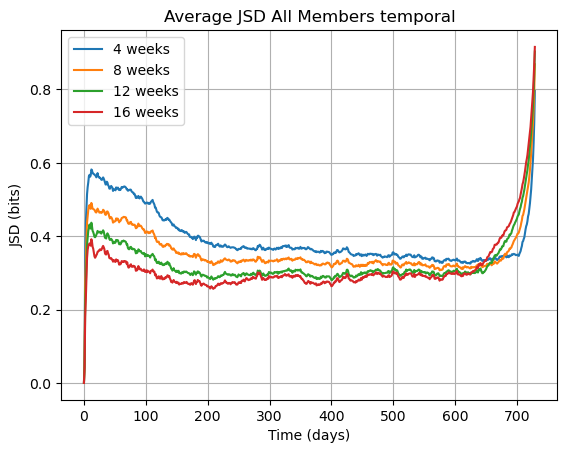

In [38]:
for i, week in enumerate(week_range):
    plt.plot(JSD_mean_temporal[i], label=f'{week} weeks')


plt.legend()
plt.ylabel('JSD (bits)')
plt.xlabel('Time (days)')
plt.grid()
plt.title('Average JSD All Members temporal')

Text(0.5, 1.0, 'Average JSD temporal vs spatial')

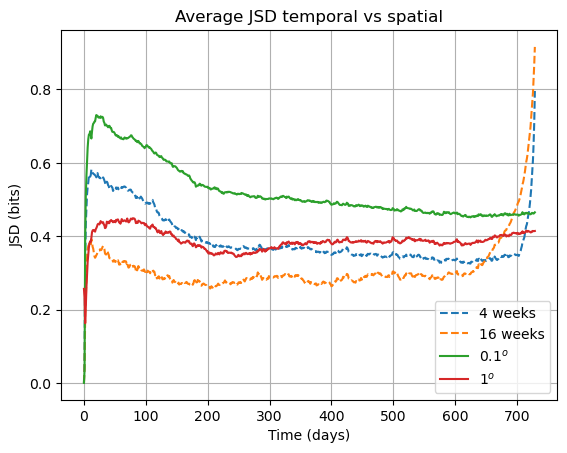

In [39]:
plt.plot(JSD_mean_temporal[0], label=f'4 weeks', ls='--')
plt.plot(JSD_mean_temporal[-1], label=f'16 weeks', ls='--')

plt.plot(JSD_mean_spatial[0], label=f'$0.1^o$')
plt.plot(JSD_mean_spatial[-1], label=f'$1^o$')

plt.legend()
plt.ylabel('JSD (bits)')
plt.xlabel('Time (days)')
plt.grid()
plt.title('Average JSD temporal vs spatial')